In [10]:
from PIL import Image
import glob
from scipy.io import loadmat 
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
objects = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\Individual_Objects_135x135.mat")
objects = objects["objects"]
labels = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\Individual_Objects_135x135_labels.mat")
labels = labels["labels"]

In [3]:
# Assign ground truth labels
labels_gt = labels[0]

In [5]:
print(objects.shape)
print(set(labels_gt))

(22402, 18225)
{0, 1, 2, 3, 4, 5, 6}


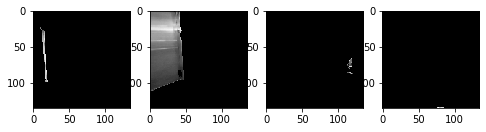

In [6]:
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(objects[i].reshape([135, 135]), cmap='gray')

### Ground-truth clusters visualization

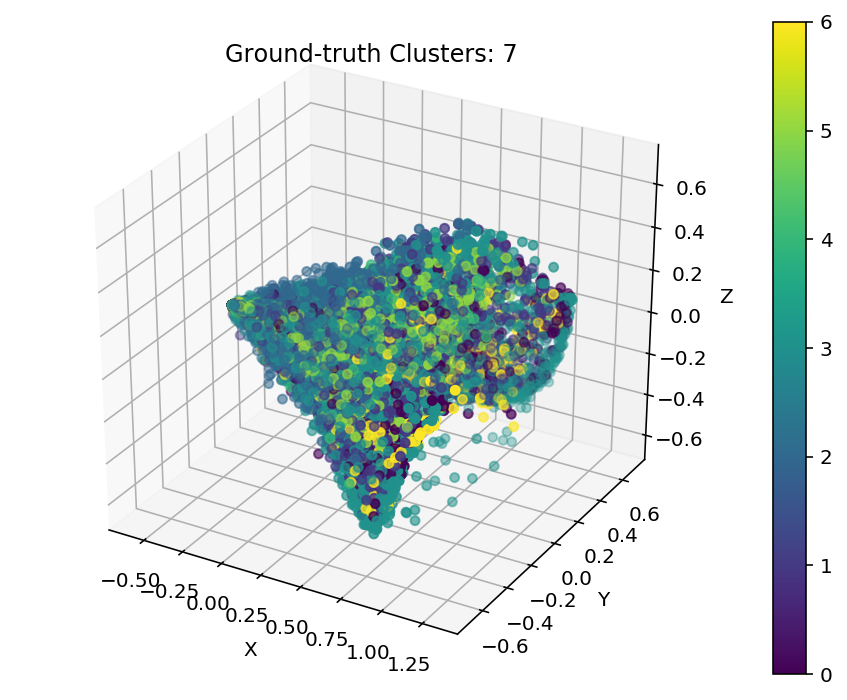

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
%config InlineBackend.figure_format='retina'

# Standardize the data to have a mean of ~0 and a variance of 1
X = StandardScaler().fit_transform(objects)
X = normalize(X)
# Create a PCA instance
pca = PCA(n_components=3)
PCA_components = pca.fit_transform(X)
# Save components as a DataFrame
PCA_components = pd.DataFrame(PCA_components)

fig = plt.figure(1, figsize=(8, 6))
ax  = fig.add_subplot(1, 1, 1, projection='3d')
axs = ax.scatter(PCA_components[0], PCA_components[1], PCA_components[2], c=labels_gt)
fig.colorbar(axs)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Ground-truth Clusters: " + str(len(set(labels_gt))))
ax.dist = 10
plt.show()

### PCA Analysis
We see that the first 3 components have huge impact on images, then then second 3 components follow them.

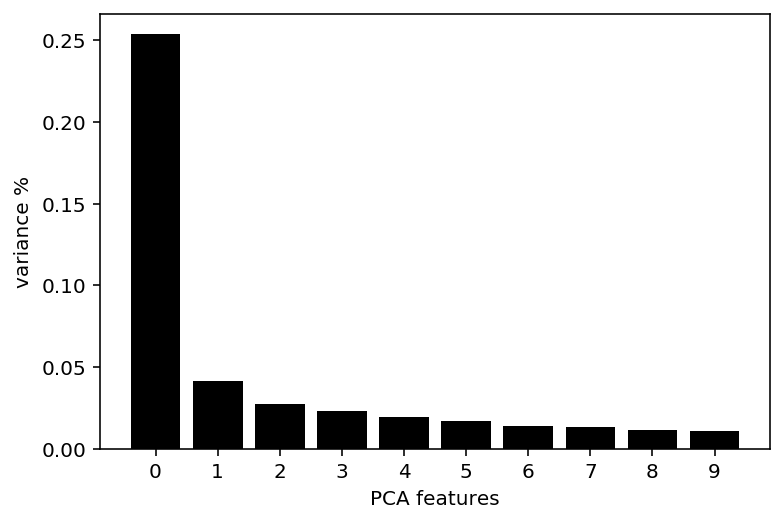

In [7]:
# Standardize the data to have a mean of ~0 and a variance of 1
X = StandardScaler().fit_transform(objects)
X = normalize(X)

# Create a PCA instance
#pca = PCA(n_components=3) # DBSCAN finds only 1 cluster with 3!
pca = PCA(10) # DBSCAN finds 6 cluster with 0.8!
PCA_components = pca.fit_transform(X)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components as a DataFrame
PCA_components = pd.DataFrame(PCA_components)

### KMEANS Analysis
Determining the best number of clusters; So, 4 is the elbow point for cluster numbers. Maybe 5 or even 6?

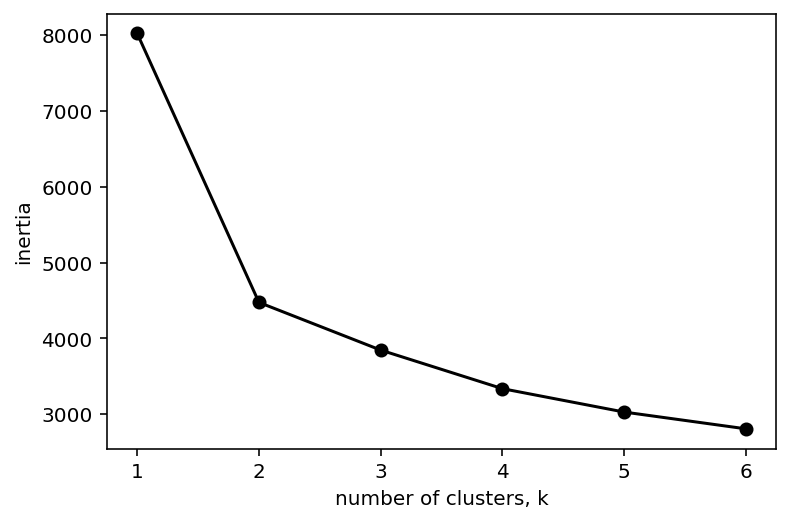

In [8]:
from sklearn.cluster import KMeans

ks = range(1, 7)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to first 10 components
    #model.fit(PCA_components.iloc[:,:10])
    model.fit(PCA_components)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

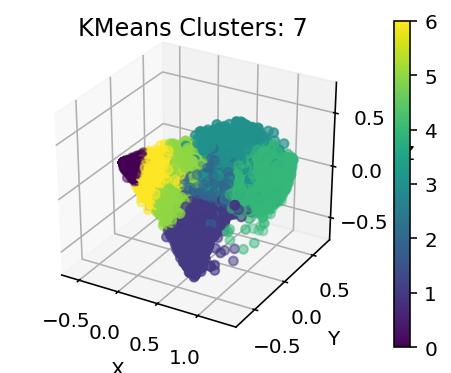

0.04378496958568492


In [14]:
# Apply kmeans and plot 3D
n_clusters = 7
#kmeans = KMeans(n_clusters).fit(PCA_components.iloc[:,:50])
kmeans = KMeans(n_clusters).fit(PCA_components)
labels_kmeans = kmeans.labels_

fig = plt.figure(1, figsize=(4, 3))
ax  = fig.add_subplot(111, projection='3d')
axs = ax.scatter(PCA_components[0],
                 PCA_components[1], 
                 PCA_components[2], 
                 c=labels_kmeans.astype(np.float))

fig.colorbar(axs)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("KMeans Clusters: " + str(n_clusters))
ax.dist = 10
plt.show()

print(str(normalized_mutual_info_score(labels_gt, labels_kmeans)))

### DBSCAN Analysis
Apply DBSCAN and plot 3D. It finds 6 clusters with eps=0.75, min_samples=14. 

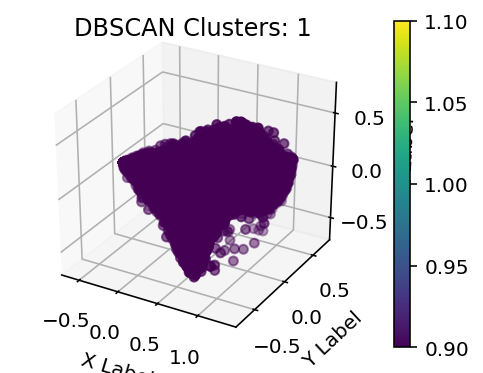

In [15]:
from sklearn.cluster import DBSCAN

# DBSCAN finds 6 clusters with PCA(.80), eps=0.75, min_samples=14
dbs = DBSCAN(eps=0.75, min_samples=14)
labels_dbscan = dbs.fit_predict(PCA_components)+1

fig = plt.figure(1, figsize=(4, 3))
ax  = fig.add_subplot(111, projection='3d')
axs = ax.scatter(PCA_components[0],
                 PCA_components[1],
                 PCA_components[2],
                 c=labels_dbscan.astype(np.float))

fig.colorbar(axs)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title("DBSCAN Clusters: " + str(len(set(labels_dbscan))))
ax.dist = 10

plt.show()

In [42]:
normalized_mutual_info_score(labels_gt, labels_dbscan)

0.024930427687004996

### Distribute images to each cluster folder 